In [5]:
import matplotlib.pyplot as plt
import matplotlib

# from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import cv2 as cv
import cv2
from google.colab.patches import cv2_imshow

from keras.models import load_model
import tensorflow as tf
from tensorflow import keras


## Get access to the drive

In [6]:
# Use 'ls' to see if the drive is available; if not, then run this
# Might need to do this once per session
from google.colab import drive
drive.mount('/content/drive/')
# Has to be done once per notebook and then get an authentication code

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
# Change directory to load the data -- change back after it has been loaded!!!
import os
os.chdir("/content/drive/My Drive/2021_Zhebin_CSThesis/ECE498_21")
!pwd
!ls

# Use a number of custom code files to make it easier to manipulate the data.
# This is the easiest way to make the modules accessible:
import sys
sys.path.append('./utils')

/content/drive/.shortcut-targets-by-id/1858s4oS_Zxg02jaj7RUg5HmBEhsNxR9D/ECE498_21
fer2013.csv				target1_static_happy.jpg
RealTime_MNetCode6_100EpochsReLU.ipynb	utils


In [8]:
# DEBUG
os.chdir("./utils")
!ls

aug_datasets.py       grad_cam.py   my_model.h5      __pycache__
data_augmentation.py  inference.py  preprocessor.py  vizualizer.py
datasets.py	      MNV2	    preproc.py


   ## Load and resize the real-time images


In [9]:
pip install opencv-python

In [10]:
# Detect the face in the image and extract the face from the image for the later prediction.

# Load the cascade
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/2021_Zhebin_CSThesis/Coding/haarcascade_frontalface_default.xml')
def face_detection(input_image_path, num, className,dir_path):
  '''
  extract face in the images. Add the new extracted image path to the extracted_image folder in drive.
  '''
  img = cv2.imread(input_image_path)

  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Detect faces
  faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
  )
  img2 = img.copy()

  # Draw rectangle around the faces
  # extract the faces
  for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2) # green color rectangle
    cropped = img2[y:y + h, x:x + w]
    
    cv2.imwrite(dir_path + className + str(num) + '.jpg', cropped)


In [11]:
import numpy as np
import PIL
from imageio import imread

import os

# This function makes the data uniformly distributed on [-1,1]
# -- we assume uniform on [0,255] coming in, then division by 255
# followed by subtraction and multiplication => [-1,1]

# normalization --> why we need to do the normalization towards the input image?

def preproc_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

# Function to convert the Grayscale Images to RGB by stacking
def aug_image(x):
    
    # convert to 3 channel (RGB)
    x = np.stack((x,)*3, axis=-1) 
    
    return x


# Convert the entire Validation Set at once
def aug_val_data(x):
    num_samples = x.shape[0]
    x_data = [aug_image(im) for im in x[0:num_samples]]
    return np.array(x_data)



# Load the data here first --- load face from drive
def load_path(file_path):
  '''
  Load the path of each image 
  return: a list of image path.
  '''
  input_dir = file_path
  input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.jpeg') or fname.endswith('.jpg')  # can detect multiple type of images
    ]
  )
  return input_img_paths

def load_faces(file_path):
  '''
  Return the nparray of each image in the file.
  '''
  input_img_paths = load_path(file_path)
  
  plt_face = []
  for i in input_img_paths:
    face = plt.imread(i)
    plt_face.append(face)
  return plt_face

#real_face=plt.imread("/content/drive/MyDrive/2021_Zhebin_CSThesis/Coding/Real_Time_Image/Image_test.jpg")

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

#resize the image in 96*96*3 - grayscale
def transform_image_in_grayscale(image_path):
  width = 96
  height = 96 
  dim = (width, height)
  resized_real_face = cv.resize(image_path,dim,interpolation = cv.INTER_AREA)
  gray = rgb2gray(resized_real_face)
  resized_face_img = np.stack((gray,)*3, axis=-1)
  return resized_face_img


def resize_image(image_path):
  '''
  Transform the image into grayscale, 
  normalize image and expand image dimension to 96*96*3
  '''
  target_image = transform_image_in_grayscale(image_path)
  nor_image = preproc_input(target_image)
  nor_image = np.expand_dims(nor_image, axis=0)
  return nor_image



#resized = []
#facial_image = load_faces(file_path)
#print(facial_image)
#for i in range(len(facial_image)):
#  resized_image = resize_image(facial_image[i])
#  resized.append(resized_image)


#### Load Image Path

In [12]:
labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']
# labels = ['sad']
file_path = '/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target2_exp7/'


classes = []

for l in labels:
  class_dir = file_path+l
  classes.append(class_dir)

for i in range(len(classes)):
  print(labels[i])
  path_name = load_path(classes[i]) # loas all the image path
  located_path_name = '/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target2_exp7_extract/' + labels[i] + "/"
  num=0
  for p in path_name:
    face_detection(p,num,labels[i],located_path_name)
    num = num+1



angry
disgust
fear
happy
sad
surprise
neutral


##### Load Trained Model


In [13]:

#load trained model
Irene_final_model_path = '/content/drive/My Drive/2021_Zhebin_CSThesis/Coding/Irene_RT5_200_Final.hdf'   # irene's model
Susy_final_model_path = '/content/drive/MyDrive/2021_Zhebin_CSThesis/Coding/susy_my_model.h5'   # susy's model


In [14]:

def predict_emotions_with_accuracy(model_path, file_path, emotion):
  new_model = load_model(Irene_final_model_path)
  image_name = load_path(file_path)

  resized = []
  result = []
  facial_image = load_faces(file_path)
  for i in range(len(facial_image)):
    resized_image = resize_image(facial_image[i])
    resized.append(resized_image)
  # predict the facial emotions
  for i in range(len(resized)):
    face = resized[i]
    y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
    y_pred1 = [np.argmax(prob) for prob in y_prob1]
    result.append(labels[y_pred1[0]])

  # calculate accuracy
  correct_prediction = 0
  for prediction in result:
    if prediction == emotion:
      correct_prediction += 1

  num_pics_total = len(result)
  print("num of images extracted: ", num_pics_total)
  print(correct_prediction)
  if num_pics_total != 0:
    accuracy = correct_prediction / num_pics_total
  else:
    accuracy = 0
  print("accuracy is: ", accuracy)



In [15]:

labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']

for emotionCate in labels:
  print(emotionCate, " accuracy is: ")
  print("\n")
  file_path = '/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target2_exp7_extract/' + emotionCate
  #predict the facial emotions
  predict_emotions_with_accuracy(Irene_final_model_path, file_path, emotionCate)
  print("\n")



angry  accuracy is: 


num of images extracted:  89
13
accuracy is:  0.14606741573033707


disgust  accuracy is: 


num of images extracted:  93
0
accuracy is:  0.0


fear  accuracy is: 


num of images extracted:  86
4
accuracy is:  0.046511627906976744


happy  accuracy is: 


num of images extracted:  85
29
accuracy is:  0.3411764705882353


sad  accuracy is: 


num of images extracted:  98
34
accuracy is:  0.3469387755102041


surprise  accuracy is: 


num of images extracted:  93
22
accuracy is:  0.23655913978494625


neutral  accuracy is: 


num of images extracted:  109
60
accuracy is:  0.5504587155963303




In [ ]:
for emotion in labels:
  file_path = '/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target2_exp1/' + emotion + '/'
  path_name = load_path(file_path)
  located_path_name = '/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target2_exp1_extract/' + emotion + "/"
  path_name_extracted = load_path(located_path_name)
  print("Image extracted for " , emotion, " are: ", len(path_name_extracted))
  print("there are: ", len(path_name), emotion, " images.")



Image extracted for  angry  are:  202
there are:  363 angry  images.
Image extracted for  disgust  are:  158
there are:  261 disgust  images.
Image extracted for  fear  are:  159
there are:  331 fear  images.
Image extracted for  happy  are:  182
there are:  418 happy  images.
Image extracted for  sad  are:  0
there are:  0 sad  images.
Image extracted for  surprise  are:  0
there are:  0 surprise  images.
Image extracted for  neutral  are:  0
there are:  0 neutral  images.


#### prediect one images and diplay

[INFO] Found 1 Faces.


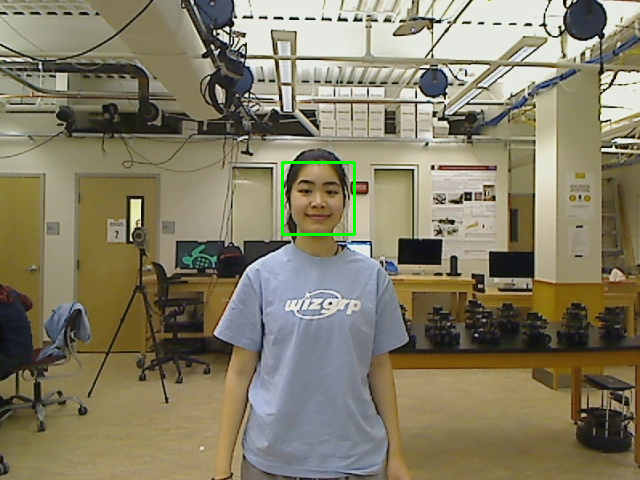

In [ ]:
# Show original image
img = cv2.imread('/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target3_exp2/happy/Feb22_Target1_emotion189.jpg')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)
print("[INFO] Found {0} Faces.".format(len(faces)))
# img2 = img.copy()
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2) # green color rectangle
    # cropped = img2[y:y + h, x:x + w]
# Display the output
cv2.startWindowThread()
cv2_imshow(img)

True:happy.
op


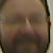

In [ ]:

def face_detection(input_image_path):
  '''
  extract face in the images. Add the new extracted image path to the extracted_image folder in drive.
  '''
  img = cv2.imread(input_image_path)

  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Detect faces
  faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
  )
  img2 = img.copy()

  # Draw rectangle around the faces
  # extract the faces
  extracted_face = []
  for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2) # green color rectangle
    cropped = img2[y:y + h, x:x + w]
    extracted_face.append(cropped)
    cv2.imwrite('/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/test_and_show/target1_exp4_extract.jpg', cropped)
  return extracted_face

  
print("True:happy.")
extracted_image = face_detection('/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target1_exp4_extract/happy/happy300.jpg')

for i in range(len(extracted_image)):
  print("op")
  cv2_imshow(extracted_image[i])





In [ ]:

labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']
image = []
image.append("/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/target3_exp2_extract/happy/happy102.jpg")
target_image = load_faces("/content/drive/MyDrive/2021_Zhebin_CSThesis/Experiment_data/test_and_show/")

resized_image = resize_image(target_image[3])
new_model = load_model(Irene_final_model_path)

y_prob1 = new_model.predict(resized_image, batch_size=32, verbose=0)
y_pred1 = [np.argmax(prob) for prob in y_prob1]

print("=======")
print("Predicted:", labels[y_pred1[0]])

Predicted: happy


### Apply face_detection in test dataset

In [ ]:
def face_detection2(image_array,dir_path,num):
  '''
  extract face in the images. Add the new extracted image path to the extracted_image folder in drive.
  '''
  # Convert into grayscale
  gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

  # Detect faces
  faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.03,
    minNeighbors=3,
    minSize=(30, 30)
  )
  img2 = image_array.copy()

  # Draw rectangle around the faces
  # extract the faces
  for (x, y, w, h) in faces:
    cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2) # green color rectangle
    cropped = img2[y:y + h, x:x + w]

    cv2.imwrite(dir_path + str(num) + '.jpg', cropped)

In [ ]:
def preproc_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to convert the Grayscale Images to RGB by stacking

def aug_image(x):
    
    # convert to 3 channel (RGB)
    x = np.stack((x,)*3, axis=-1) 
    
    return x

# Convert the entire Validation Set at once
def aug_val_data(x):
    num_samples = x.shape[0]
    x_data = [aug_image(im) for im in x[0:num_samples]]
    return np.array(x_data)



# Load the data here first

from aug_datasets import DataManager
from aug_datasets import split_valtest_data

# Split into Training, Validation, and Test sets so we can determine the 
# performance based on the test set. 

# Parameters for NN
batch_size = 32

# Reshape the face data for MobileNet -- has to be in 96x96x3
input_shape = (96, 96, 3)
verbose = 1
num_classes = 7
patience = 30

dataset_name = 'fer2013'
print('Training dataset:', dataset_name)

dataset_path='/content/drive/My Drive/2021_Zhebin_CSThesis/ECE498_21/fer2013.csv'

# The DataManager class supports many different datasets. For now, it will
# just be used to import FER2013 but can be expanded to do more later.
data_loader = DataManager(dataset_name, dataset_path, image_size=input_shape[:2])

# Load the data which is just FER2013 and resize to 96x96 -- this returns
# a Numpy array which is float32 and the right dimensions

faces, emotions = data_loader.get_data()

# Normalizes the data to [-1,1]
faces = preproc_input(faces)


# Split the data into three parts
train_data, val_data, test_data = split_valtest_data(faces, emotions)

train_faces, train_emotions = train_data
val_faces, val_emotions = val_data
test_faces, test_emotions = test_data




Training dataset: fer2013


In [ ]:


test_faces_aug = aug_val_data(test_faces)



y_prob1 = new_model.predict(test_faces_aug, batch_size=32, verbose=0)
y_pred1 = [np.argmax(prob) for prob in y_prob1]
y_true = [np.argmax(true) for true in test_emotions]

print("\n\n Accuracy: ")
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred1)




 Accuracy: 


0.6792978545555866

In [ ]:
test_faces_aug = aug_val_data(test_faces)

extracted_face = []
for i in range(len(test_faces_aug)):
  faces = test_faces_aug[i].astype(np.uint8)
  extracted = face_detection2(faces,'/content/drive/MyDrive/2021_Zhebin_CSThesis/Real_Time_Image/test_dataset_extract/',i)
  # Normalizes the data to [-1,1]


error: ignored

In [ ]:

# get the total number images of extracted images
extracted_path = '/content/drive/MyDrive/2021_Zhebin_CSThesis/Real_Time_Image/test_dataset_extract/'
num_path = load_path(extracted_path)
print(len(num_path))

2551


In [ ]:

image_name = load_path(extracted_path)

resized = []
facial_image = load_faces(extracted_path)
for i in range(len(facial_image)):
  resized_image = resize_image(facial_image[i])
  resized.append(resized_image)

correct = 0
# predict the facial emotions
for i in range(len(resized)):
  face = resized[i]
  y_prob1 = new_model.predict(face, batch_size=32, verbose=0)
  y_pred1 = [np.argmax(prob) for prob in y_prob1]
  jpg_name = image_name[i]
  x = jpg_name.split(".")
  x2 = x[0].split("/")
  position = x2[7]
  y_true_label = np.argmax(int(position))
  y_true = np.argmax(test_emotions[int(position)])
  if labels[y_pred1[0]] == labels[y_true]:
    correct += 1
  #print("The predicted image emotion is: ", labels[y_pred1[0]], labels[y_true])
accuracy = correct/len(resized)
print(accuracy)

0.6546452371618973
